In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import math
import scipy.stats as stats
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


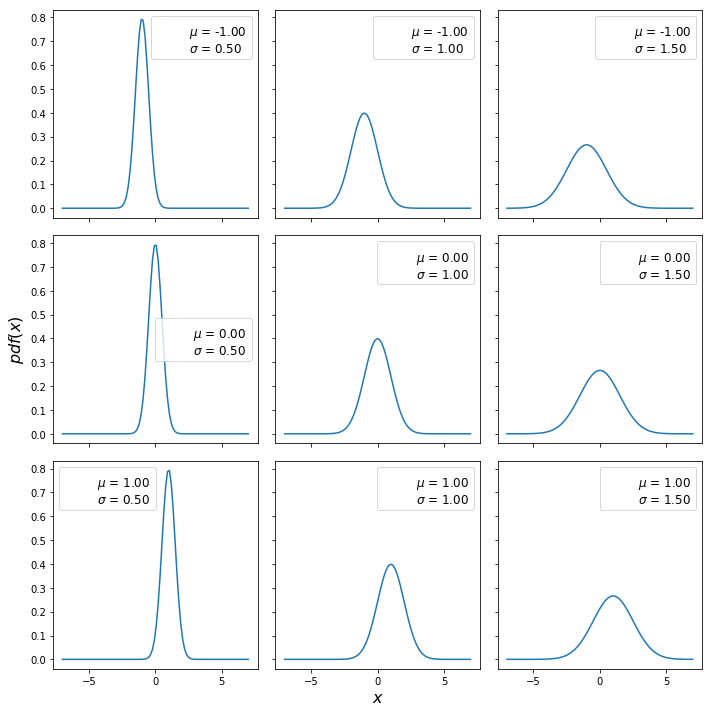

In [6]:
mu_params = [-1, 0, 1]
sd_params = [0.5, 1, 1.5]
x = np.linspace(-7, 7, 100)
f, ax = plt.subplots(len(mu_params), len(sd_params), sharex=True, sharey=True,figsize = (10,10))
for i in range(3):
    for j in range(3):
        mu = mu_params[i]
        sd = sd_params[j]
        y = stats.norm(mu, sd).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0,label="$\\mu$ = {:3.2f}\n$\\sigma$ = {:3.2f}".format (mu, sd), alpha=0)
        ax[i,j].legend(fontsize=12) 
        ax[2,1].set_xlabel('$x$', fontsize=16)
        ax[1,0].set_ylabel('$pdf(x)$', fontsize=16)
        plt.tight_layout()

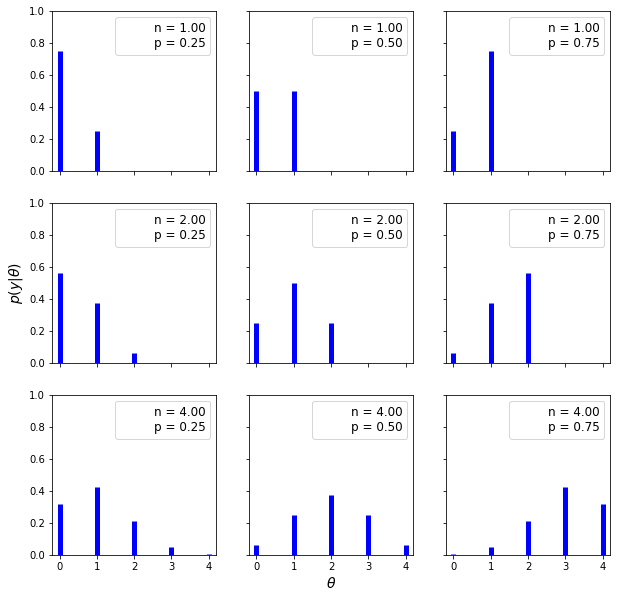

In [10]:
n_params = [1, 2, 4]
p_params = [0.25, 0.5, 0.75]
x = np.arange(0, max(n_params)+1)
f, ax = plt.subplots(len(n_params), len(p_params), sharex=True, sharey=True,figsize = (10,10))
for i in range(3): 
    for j in range(3):
        n = n_params[i]
        p = p_params[j]
        y = stats.binom(n=n, p=p).pmf(x)
        ax[i,j].vlines(x, 0, y, colors='b', lw=5)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].plot(0, 0, label="n = {:3.2f}\np = {:3.2f}".format(n, p), alpha=0)
        ax[i,j].legend(fontsize=12)
ax[2,1].set_xlabel('$\\theta$', fontsize=14)
ax[1,0].set_ylabel('$p(y|\\theta)$', fontsize=14)
ax[0,0].set_xticks(x);

Text(0,0.5,'$p(\\theta)$')

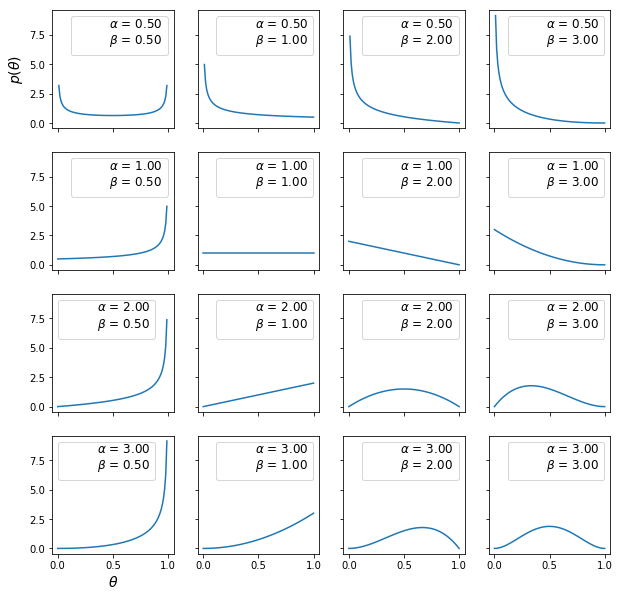

In [11]:
params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True,figsize = (10,10))
for i in range(4): 
    for j in range(4):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x) 
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="$\\alpha$ = {:3.2f}\n$\\beta$ = {:3.2f}".format(a, b), alpha=0)
        ax[i,j].legend(fontsize=12)
ax[3,0].set_xlabel('$\\theta$', fontsize=14) 
ax[0,0].set_ylabel('$p(\\theta)$', fontsize=14)

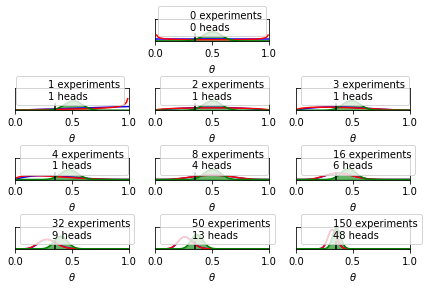

In [14]:
theta_real = 0.35
trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
beta_params = [(1, 1), (0.5, 0.5), (20, 20)]
dist = stats.beta
x = np.linspace(0, 1, 100)
for idx, N in enumerate(trials):
    if idx == 0:
        plt.subplot(4,3, 2)
    else:
        plt.subplot(4,3, idx+3)
    y = data[idx]
    for (a_prior, b_prior), c in zip(beta_params, ('b', 'r', 'g')):
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.plot(x, p_theta_given_y, c)
    plt.fill_between(x, 0, p_theta_given_y, color=c, alpha=0.6)
    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label="{:d} experiments\n{:d} heads".format(N, y), alpha=0)
    plt.xlim(0,1) 
    plt.ylim(0,12)
    plt.xlabel(r'$\theta$') 
    plt.legend()
    plt.gca().axes.get_yaxis().set_visible(False) 
    plt.tight_layout()

In [15]:
def naive_hpd(post):
    sns.kdeplot(post)
    HPD = np.percentile(post, [2.5, 97.5])
    plt.plot(HPD, [0, 0], label='HPD {:.2f} {:.2f}'.format(*HPD), linewidth=8, color='k')
    plt.legend(fontsize=16);
    plt.xlabel(r'$\theta$', fontsize=14)
    plt.gca().axes.get_yaxis().set_ticks([])

(0, 1)

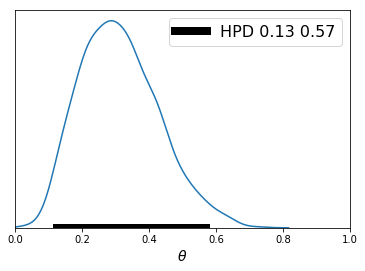

In [16]:
np.random.seed(1)
post = stats.beta.rvs(5, 11, size=1000)
naive_hpd(post)
plt.xlim(0, 1)

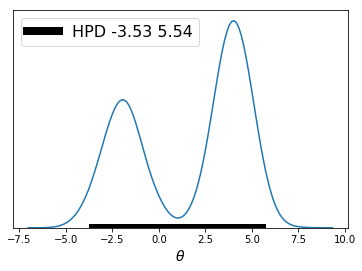

In [17]:
np.random.seed(1)
gauss_a = stats.norm.rvs(loc=4, scale=0.9, size=3000)
gauss_b = stats.norm.rvs(loc=-2, scale=1, size=2000)
mix_norm = np.concatenate((gauss_a, gauss_b))
naive_hpd(mix_norm)

In [18]:
from plot_post import plot_post
plot_post(mix_norm, roundto=2, alpha=0.05)
plt.legend(loc=0, fontsize=16) 
plt.xlabel(r"$\theta$", fontsize=14)

ModuleNotFoundError: No module named 'plot_post'

In [19]:
def posterior_grid(grid_points=100, heads=6, tosses=9):
    """A grid implementation for the coin-flip problem """
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(5, grid_points)
    likelihood = stats.binom.pmf(heads, tosses, grid)
    unstd_posterior = likelihood * prior 
    posterior = unstd_posterior / unstd_posterior.sum() 
    return grid, posterior

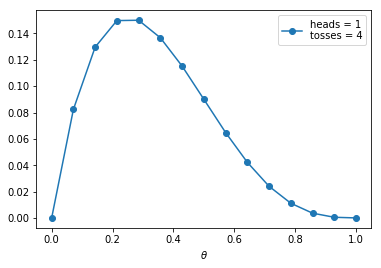

In [21]:
points = 15 
h, n = 1, 4
grid, posterior = posterior_grid(points, h, n)
plt.plot(grid, posterior, 'o-', label='heads = {}\ntosses = {}'.format(h, n))
plt.xlabel(r'$\theta$') 
plt.legend(loc=0)

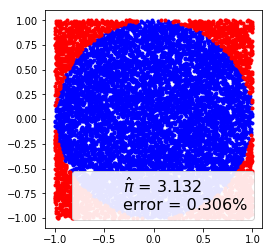

In [22]:

N = 10000
x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi)/pi)* 100
outside = np.invert(inside)
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label='$\hat \pi$ = {:4.3f}\nerror = {:4.3f}%'.format(pi, error), alpha=0)
plt.axis('square')
plt.legend(frameon=True, framealpha=0.9, fontsize=16);

In [24]:
def metropolis(func, steps=10000):
    """A very simple Metropolis implementation""" 
    samples = np.zeros(steps) 
    old_x = func.mean() 
    old_prob = func.pdf(old_x)
    for i in range(steps):
        new_x = old_x + np.random.normal(0, 0.5)
        new_prob = func.pdf(new_x) 
        acceptance = new_prob/old_prob 
        if acceptance >= np.random.random(): 
            samples[i] = new_x 
            old_x = new_x
            old_prob = new_prob
        else: 
            samples[i] = old_x 
    return samples

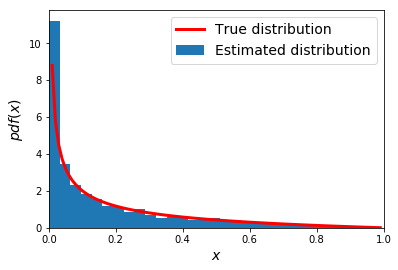

In [26]:

func = stats.beta(0.4, 2) 
samples = metropolis(func=func)
x = np.linspace(0.01, .99, 100)
y = func.pdf(x)
plt.xlim(0, 1)
plt.plot(x, y, 'r-', lw=3, label='True distribution') 
plt.hist(samples, bins=30, normed=True, label='Estimated distribution')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14) 
plt.legend(fontsize=14)

# Pymc3

In [3]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments) 
print(data)

[1 0 0 0]


In [ ]:
with pm.model as first_pm_model:
    theta = pm.Beta('theta',alpha=1,beta=2)
    y = pm.Bernoulli('y',p=theta,observed=data)

In [ ]:
start = pm.find_MAP()
step = pm.Metropolice()
trace = pm.sample(1000,start=start,step=step)